# Circularity

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from auriga.images import figure_setup, set_axs_configuration
from auriga.snapshot import Snapshot
from auriga.settings import Settings
from auriga.mathematics import pdf_gaussian, gaussian
from auriga.mathematics import double_pdf_gaussian, double_gaussian

In [10]:
figure_setup()

In [3]:
def load_subhalo_star_circ(simulation: str) -> np.ndarray:
    """
    This method returns the circularity of the stars in the main subhalo for
    a given simulation.

    Parameters
    ----------
    simulation : str
        The simulation to load.

    Returns
    -------
    np.ndarray
        The circularity.
    """
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    return s.circularity[(s.type == 4) \
        & (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)]

## Circularity Distribution Plots

In [6]:
def add_panel_for_galaxy(simulation: str, ax: plt.Axes):
    """
    This method adds a panel with the results for a given simulation.

    Parameters
    ----------
    simulation : str
        The simulation.
    ax : plt.Axes
        The ax to which to add the plot.
    """

    circularity = load_subhalo_star_circ(simulation=simulation)
    ax.hist(x=circularity,
            bins=150,
            range=(-2.0, 2.0),
            histtype="step",
            density=True,
            label=r"$\texttt{" + simulation.upper() + "}$")
    ax.text(x=0.05,
            y=0.95,
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=6.0, transform=ax.transAxes,
            ha='left', va='top',
            )

In [9]:
def plot_circularity_for_sample(simulations: list, filename: str):
    """
    This method creates a plot of the circularity distribution for the
    stars in the main object.

    Parameters
    ----------
    simulations : str
        A list of simulations to plot.
    filename : str
        The name of the output file.
    """

    n_simulations = len(simulations)

    fig = plt.figure(figsize=(7.2, 7.2))
    gs = fig.add_gridspec(nrows=6, ncols=5, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    set_axs_configuration(
        xlim=(-2, 2), ylim=(0, 2),
        xticks=[-1, 0, 1], yticks=[0, 0.5, 1, 1.5],
        xlabel="$\epsilon$", ylabel="PDF",
        axs=axs, n_used=n_simulations)

    for idx, ax in enumerate(axs.flat):
        ax.grid(True, ls='-', lw=0.25, c='silver')
        if idx < n_simulations:
            add_panel_for_galaxy(simulations[idx], ax=ax)
        else:
            ax.axis("off")

    for ext in ["pdf", "png"]:
        fig.savefig(f"../images/circularity/{filename}.{ext}")
    plt.close(fig)

In [8]:
# Create plots for all galaxies in two figures
settings = Settings()
originals = [f"au{i}_or_l4_s127" for i in settings.galaxies]
reruns = [f"au{i}_re_l4_s251" for i in settings.reruns]
plot_circularity_for_sample(simulations=originals, filename="originals_s127")
plot_circularity_for_sample(simulations=reruns, filename="reruns_s251")

## Fitting the Circularity Distribution

In [4]:
circularity = load_subhalo_star_circ(simulation="au6_or_l4_s127")

In [5]:
hist, bin_edges = np.histogram(
    a=circularity,
    bins=150,
    range=(-2.0, 2.0),
    density=True)
bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2

### Using a Standard Gaussian Function

In [54]:
popt, pcov = curve_fit(
    f=double_gaussian,
    xdata=bin_centers,
    ydata=hist,
    p0=(      0.3,    0.0,  0.1,    1.5,   1.0,   0.1,),
    bounds=[(0.01,   -0.6, 0.01,   0.01,   0.8,  0.01,),
            (np.inf,  0.6,  1.0, np.inf,   1.2,   1.0,)])
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

[0.46279296 0.47606856 0.68651776 1.18527914 0.95113792 0.20672808]
[0.00811556 0.01456054 0.01333244 0.01619173 0.00171788 0.00330593]


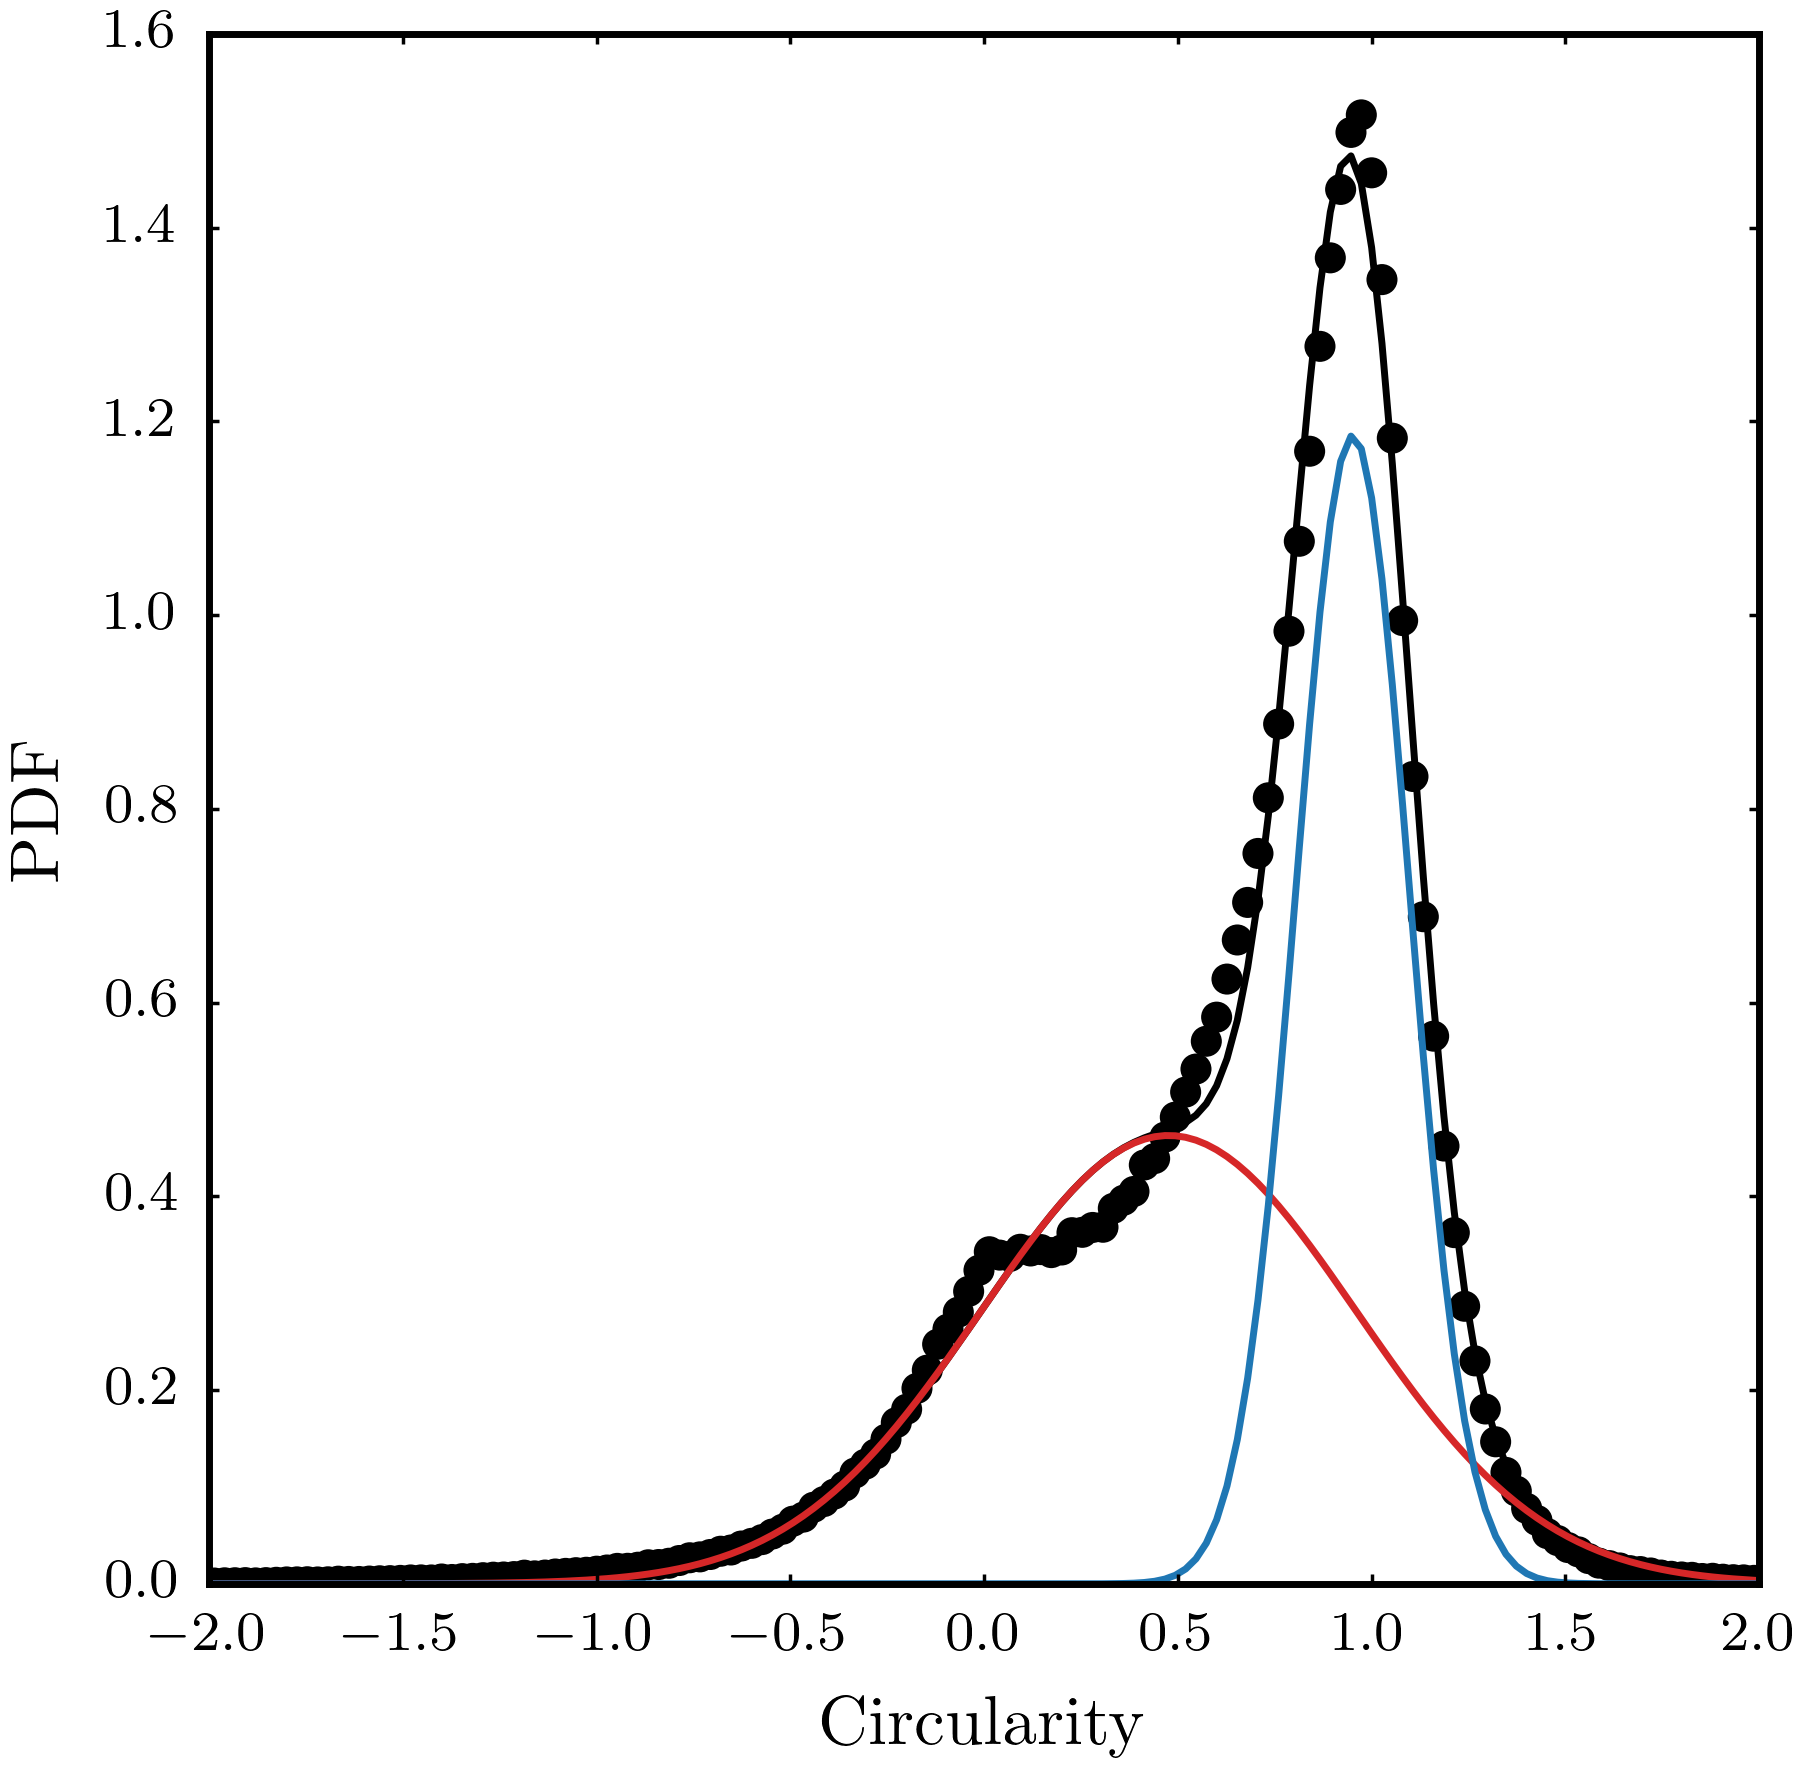

In [55]:
fig = plt.figure(figsize=(4.0, 4.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_xlabel("Circularity")
ax.set_xlim(-2, 2)

ax.set_ylabel("PDF")
ax.set_ylim(0, 1.6)

ax.scatter(bin_centers, hist, edgecolors="none", color='k')
ax.plot(bin_centers, double_gaussian(bin_centers, *popt), color='k')
ax.plot(bin_centers, gaussian(bin_centers, *popt[:3]), color="tab:red")
ax.plot(bin_centers, gaussian(bin_centers, *popt[3:6]), color="tab:blue")

plt.show()

### Using the PDF Gaussian

In [59]:
popt, pcov = curve_fit(
    f=double_pdf_gaussian,
    xdata=bin_centers,
    ydata=hist,
    p0=(      0.0,  0.1,  1.0,   0.1,),
    # bounds=[(-0.2, 0.01,  0.8,  0.01,),
    #         ( 2.2,  np.inf,  1.2,   1.0,)],
    )
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

[-6.74068041  3.03016132  0.85268913  0.33030627]
[5.2288344  3.84267295 0.01330201 0.01081931]


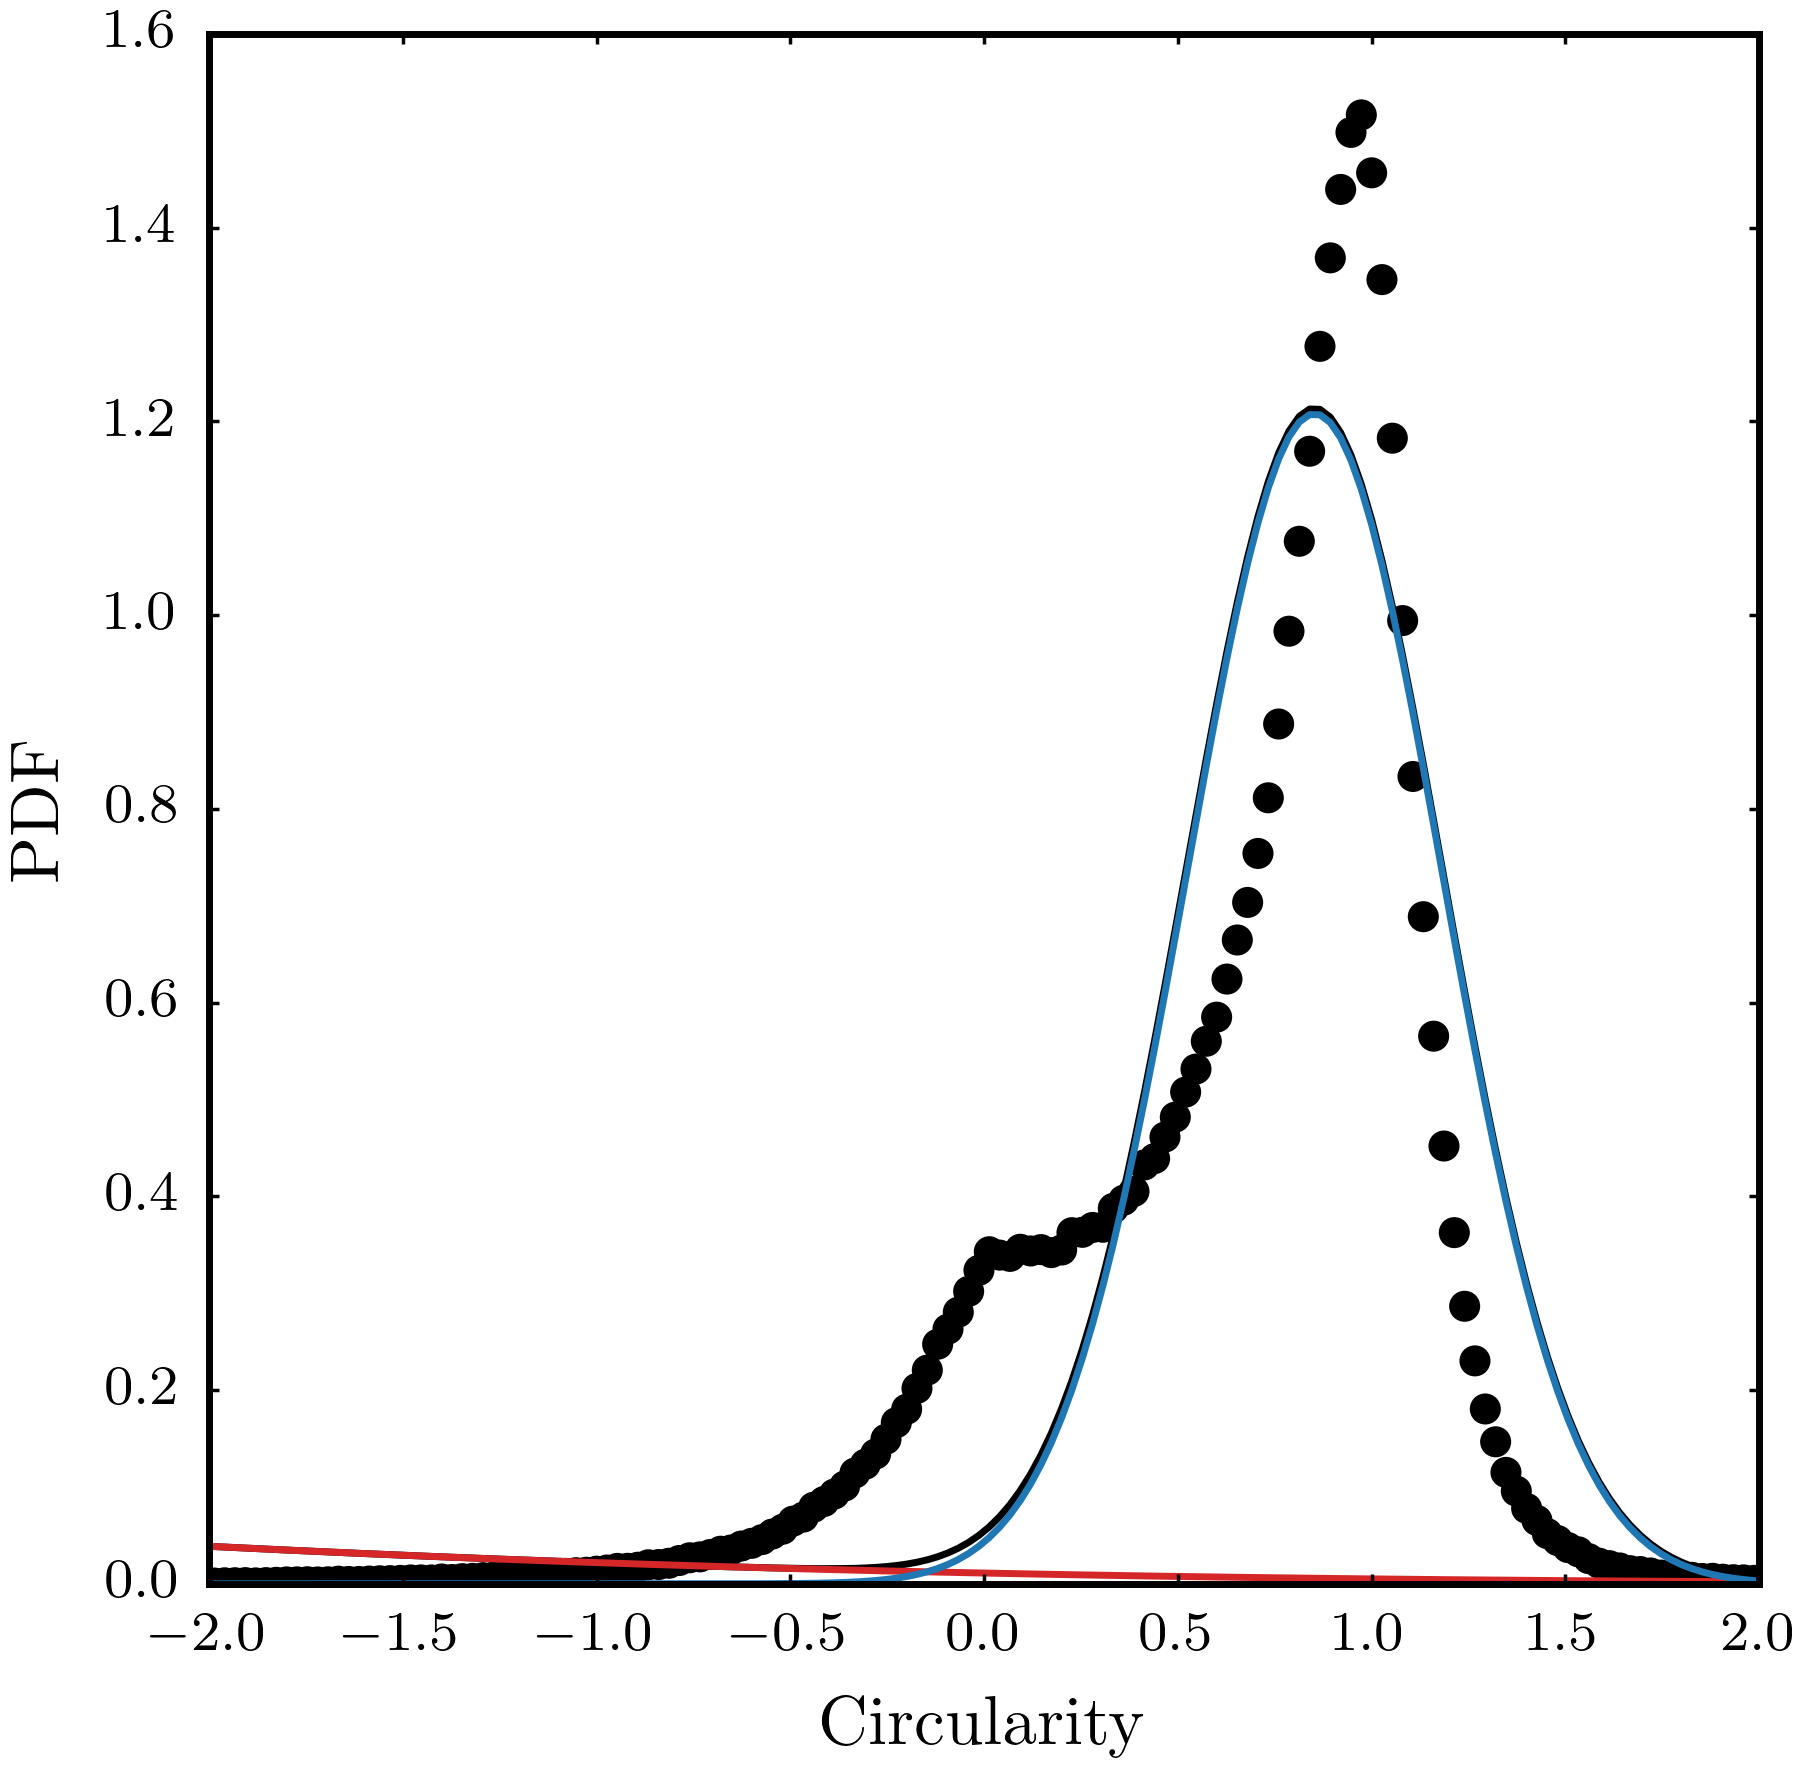

In [60]:
fig = plt.figure(figsize=(4.0, 4.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_xlabel("Circularity")
ax.set_xlim(-2, 2)

ax.set_ylabel("PDF")
ax.set_ylim(0, 1.6)

ax.scatter(bin_centers, hist, edgecolors="none", color='k')
ax.plot(bin_centers, double_pdf_gaussian(bin_centers, *popt), color='k')
ax.plot(bin_centers, pdf_gaussian(bin_centers, *popt[:2]), color="tab:red")
ax.plot(bin_centers, pdf_gaussian(bin_centers, *popt[2:4]), color="tab:blue")

plt.show()

### By-Hand Method

In [6]:
disc_x = bin_centers[hist >= 0.7]
disc_y = hist[hist >= 0.7]

In [21]:
disk_popt, disk_pcov = curve_fit(
    f=gaussian,
    xdata=disc_x,
    ydata=disc_y,
    p0=(2.0, 1.0, 0.2),
    # bounds=[(1.3,   0.95,   0.01,),
    #         (1.6,   1.05,    1.0,)],
    )
disk_perr = np.sqrt(np.diag(disk_pcov))

print(disk_popt)
print(disk_perr)

[1.43783725 0.93667861 0.264179  ]
[0.03347054 0.00636736 0.01309061]


In [23]:
bulge_y = hist - gaussian(bin_centers, *disk_popt)

bulge_popt, bulge_pcov = curve_fit(
    f=gaussian,
    xdata=bin_centers,
    ydata=bulge_y,
    p0=(0.5, 0.1, 0.4),
    # bounds=[(1.3,   0.95,   0.01,),
    #         (1.6,   1.05,    1.0,)],
    )
bulge_perr = np.sqrt(np.diag(bulge_pcov))

print(bulge_popt)
print(bulge_perr)

[0.41128273 0.22847246 0.45773942]
[0.01356816 0.01233041 0.01743784]


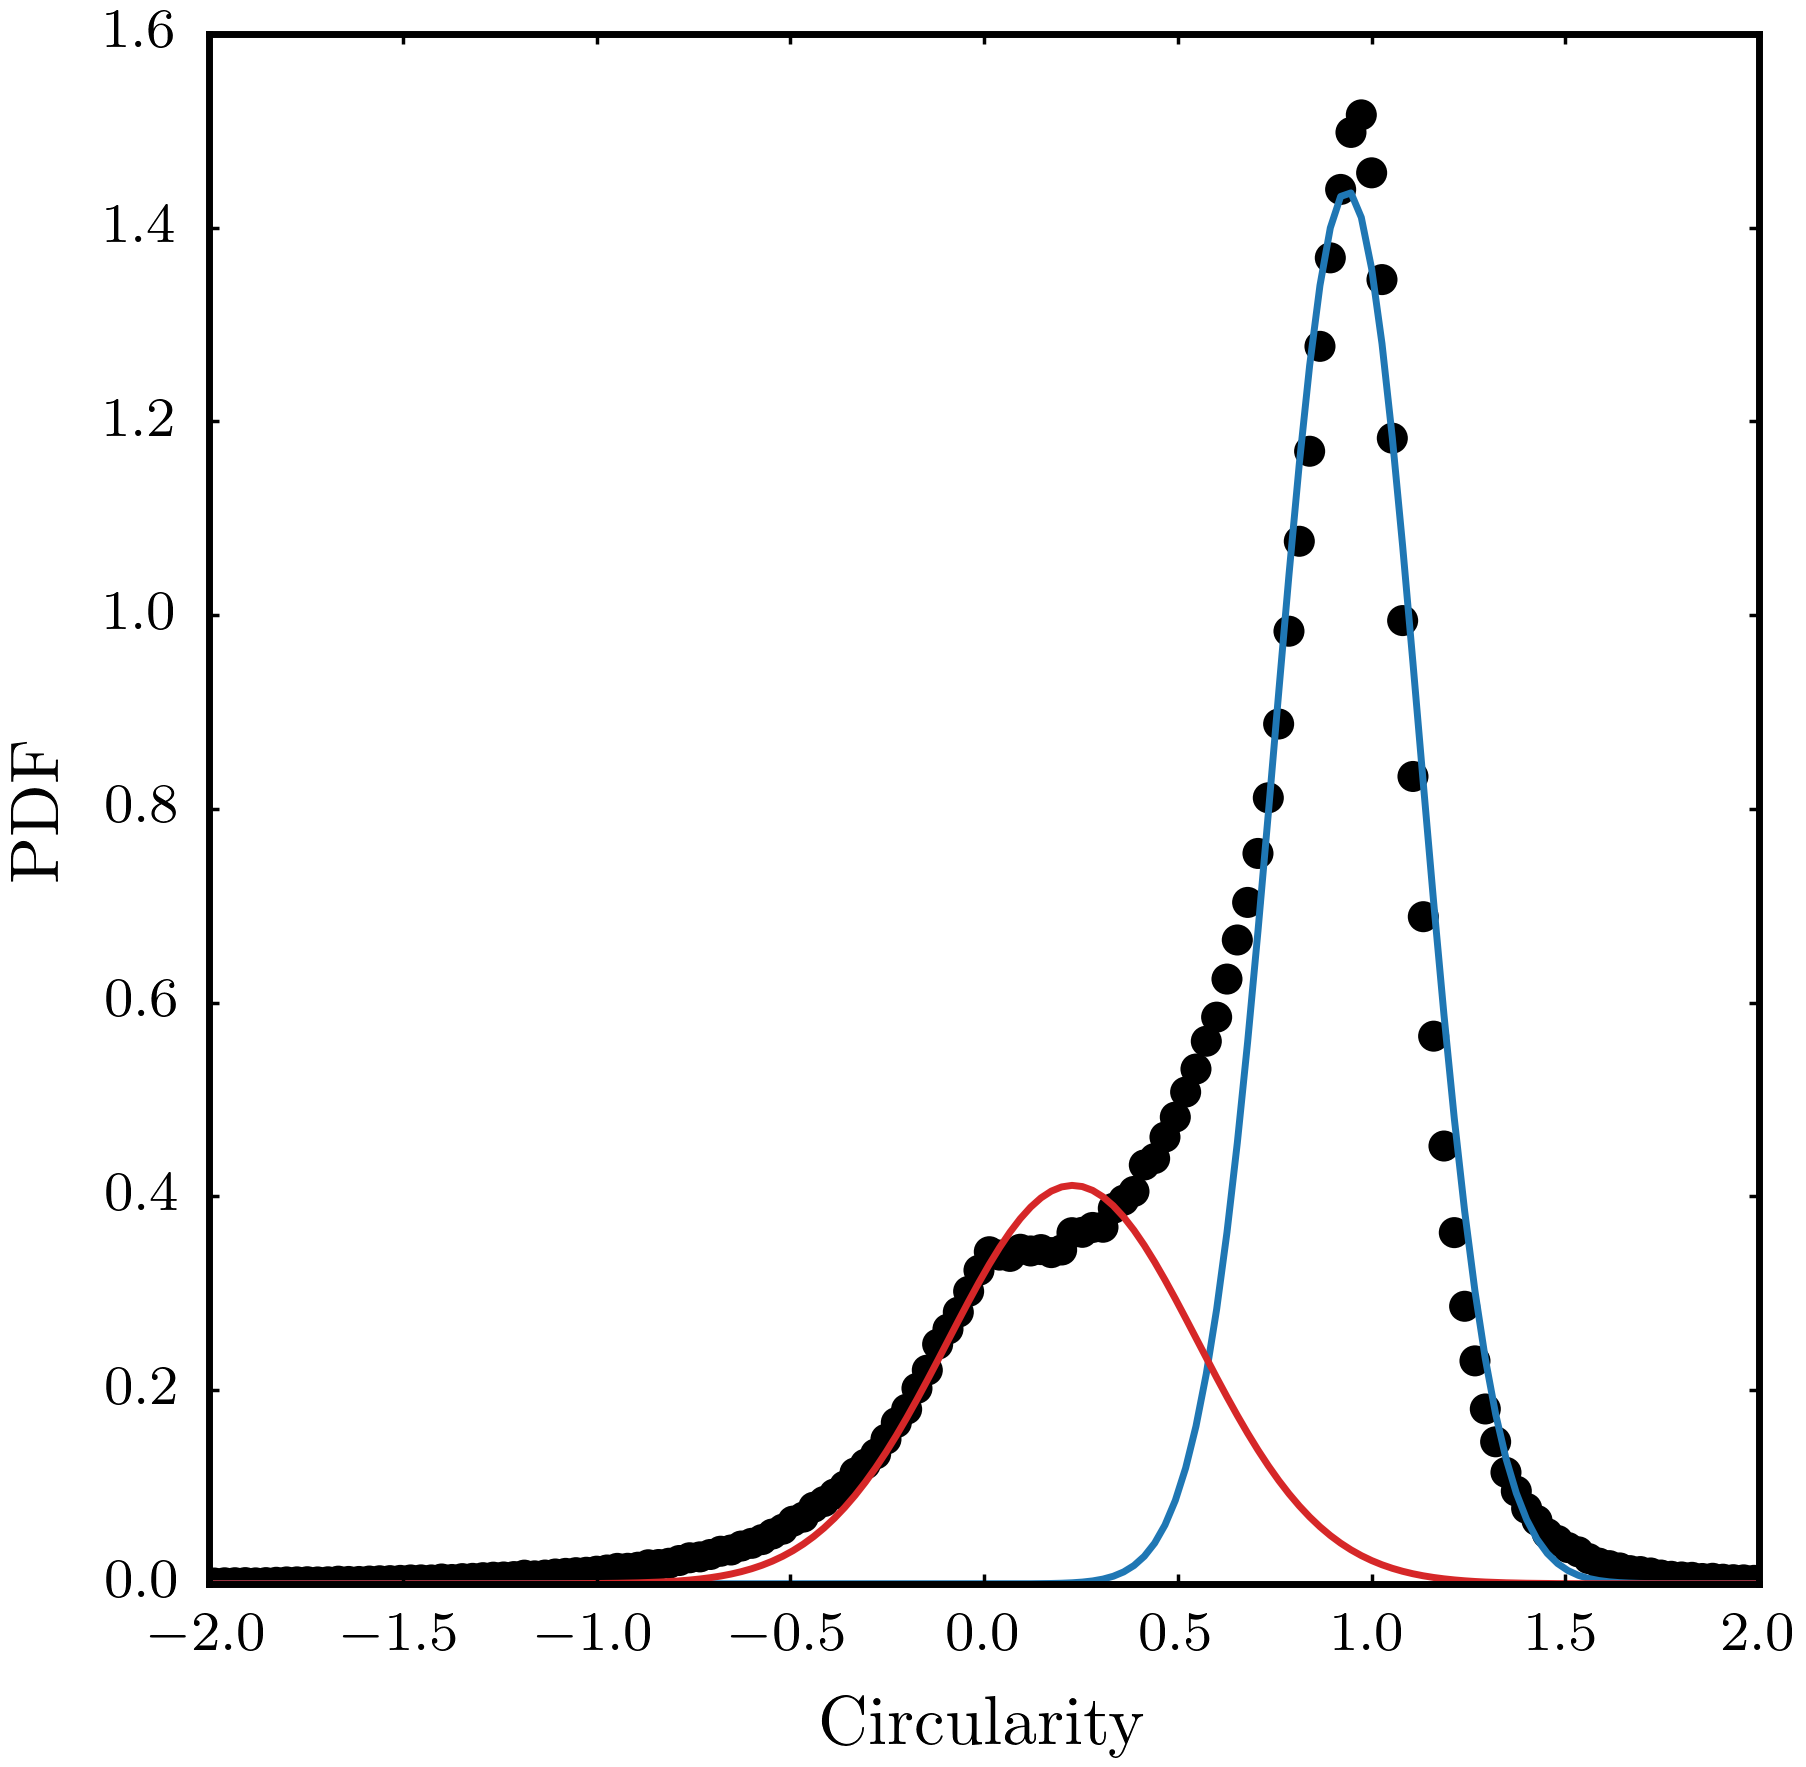

In [24]:
fig = plt.figure(figsize=(4.0, 4.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_xlabel("Circularity")
ax.set_xlim(-2, 2)

ax.set_ylabel("PDF")
ax.set_ylim(0, 1.6)

ax.scatter(bin_centers, hist, edgecolors="none", color='k')
# ax.scatter(bin_centers, bulge_y, edgecolors="none", color="tab:red")
ax.plot(bin_centers, gaussian(bin_centers, *disk_popt), color="tab:blue")
ax.plot(bin_centers, gaussian(bin_centers, *bulge_popt), color="tab:red")
# ax.plot(bin_centers, gaussian_with_bulge_params(bin_centers, *disk_popt),
#         color="tab:purple")

plt.show()

## HWHM Calculation

In [177]:
disk_max_idx = np.argmin(np.abs(bin_centers - 1.0))
disk_half_max = hist[disk_max_idx] / 2.0

disk_right_x = bin_centers[bin_centers >= 1.0][np.argmin(np.abs(hist[bin_centers >= 1.0] - disk_half_max))]
disk_right_y = hist[bin_centers >= 1.0][np.argmin(np.abs(hist[bin_centers >= 1.0] - disk_half_max))]
disk_left_x = bin_centers[bin_centers <= 1.0][np.argmin(np.abs(hist[bin_centers <= 1.0] - disk_half_max))]
disk_left_y = hist[bin_centers <= 1.0][np.argmin(np.abs(hist[bin_centers <= 1.0] - disk_half_max))]

disk_fwhm = disk_right_x - disk_left_x
disk_hwhm = disk_fwhm / 2.0

disk_sigma = disk_fwhm / 2.355
print(f"Disk HWHM: {disk_sigma}")

Disk HWHM: 0.19249823071479139


In [178]:
bulge_max_idx = np.argmin(np.abs(bin_centers))
bulge_half_max = hist[bulge_max_idx] / 2.0

bulge_left_x = bin_centers[bin_centers <= 0.0][np.argmin(np.abs(hist[bin_centers <= 0.0] - bulge_half_max))]
bulge_left_y = hist[bin_centers <= 0.0][np.argmin(np.abs(hist[bin_centers <= 0.0] - bulge_half_max))]

bulge_hwhm = np.abs(bulge_left_x)
bulge_fwhm = 2.0 * bulge_hwhm

bulge_sigma = bulge_fwhm / 2.355
print(f"Bulge HWHM: {bulge_sigma}")

Bulge HWHM: 0.19249823071479105


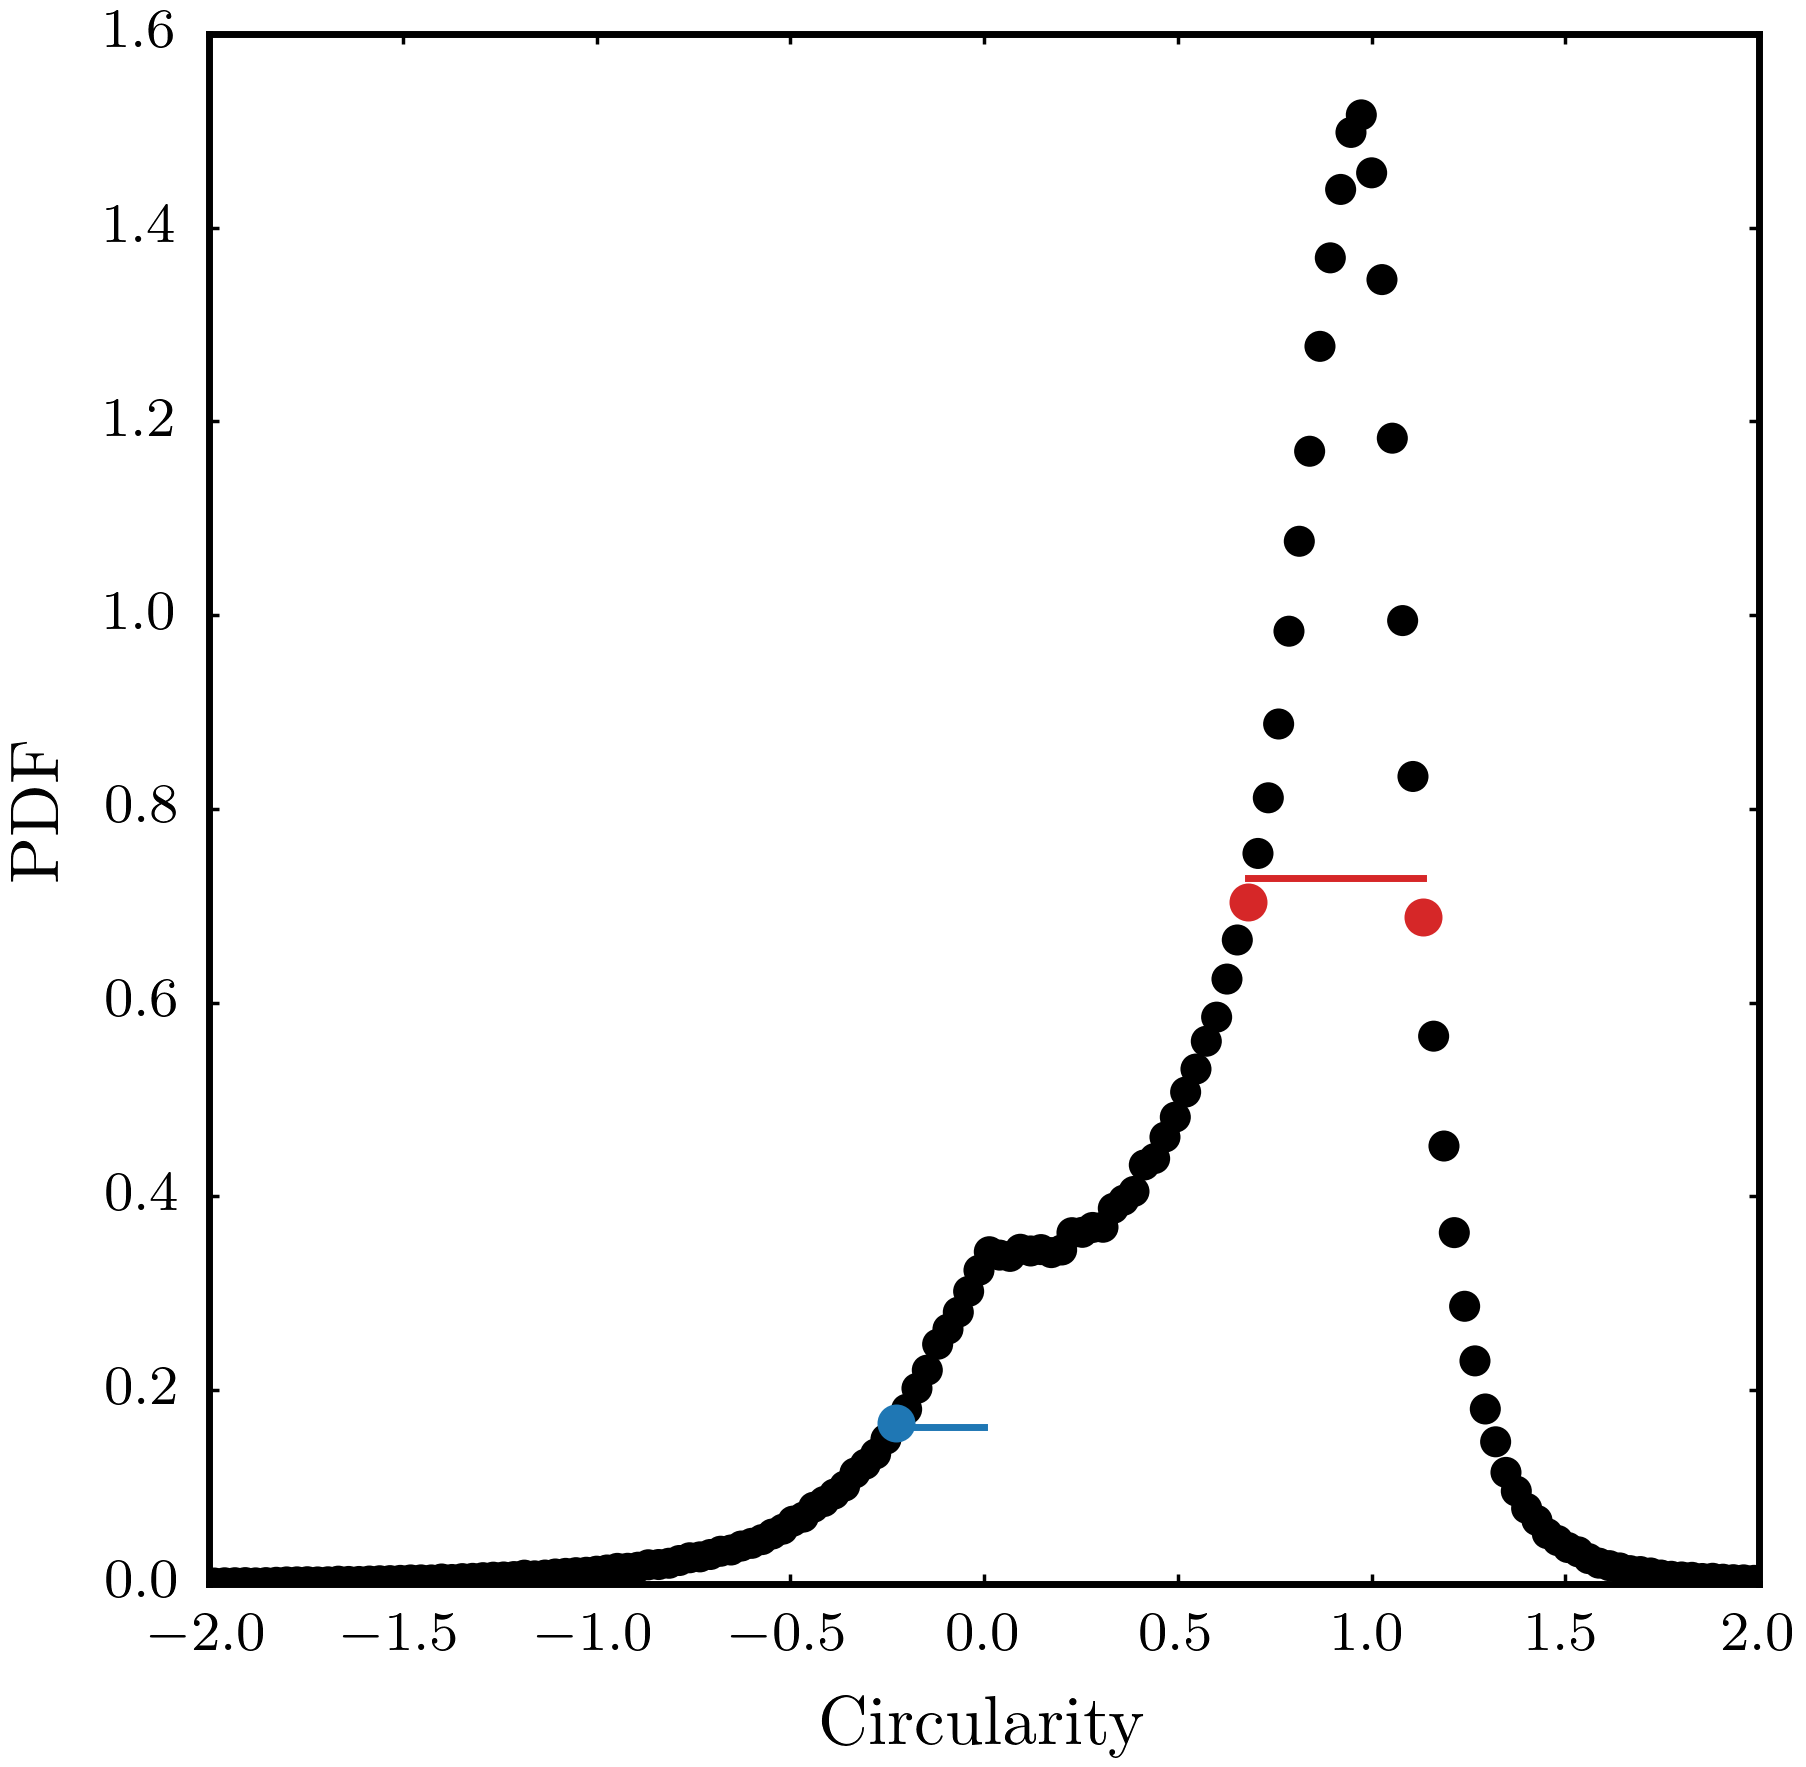

In [166]:
fig = plt.figure(figsize=(4.0, 4.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

ax.set_xlabel("Circularity")
ax.set_xlim(-2, 2)

ax.set_ylabel("PDF")
ax.set_ylim(0, 1.6)

ax.scatter(bin_centers, hist, edgecolors="none", color='k')

ax.scatter([left_x, right_x], [left_y, right_y], color="tab:red")
ax.plot([left_x, right_x], [half_max, half_max], color="tab:red")

ax.scatter([bulge_left_x], [bulge_left_y], color="tab:blue")
ax.plot([bulge_left_x, 0], [bulge_half_max, bulge_half_max], color="tab:blue")

plt.show()